In [1]:
import cbayes.sample
import cbayes.distributions
import cbayes.solve
import numpy as np
import ipywidgets as wd
import matplotlib.pyplot as plt
import scipy.stats as sstats
import scipy.spatial as spat

The following linear map $Q_s: \mathbb{R}^2 \to \mathbb{R}^2$ is defined to have skewness $s$ at all $\lambda \in \Lambda$.  

$$
Q_s(\lambda) = \lbrace \, \lambda_1, \; \lambda_1 \sqrt{s^2 - 1} + \lambda_2 \, \rbrace
$$

### Useful Identities
Let $\lambda$ denote an arbitrary Gaussian random variable with mean $\mu_\lambda$ and covariance $\Sigma_\lambda$,
$$
\lambda \sim N\left(\mu_\lambda, \Sigma_\lambda\right).
$$
Then, for a matrix $A$, 
$$
A\lambda \sim N\left(A\mu_\lambda,\, A\Sigma_\lambda A^T\right)
$$
Let $\eta = A\lambda + e$, where $e\sim N(0,\Sigma_e)$,   
then the posterior $p(\lambda | \eta)$ is given by

$$
p(\lambda | \eta=\bar{\eta}) = N\left(\hat{\mu}, \hat{\Sigma}\right),
$$
where 
$$
\hat{\mu} = \mu_\lambda + \Sigma_\lambda A^T\left(A\Sigma_\lambda A^T + \Sigma_e\right)^{-1}\left(\bar{\eta} - A\mu_\lambda\right)
$$
and
$$
\hat{\Sigma} = \Sigma_\lambda - \Sigma_\lambda A^T\left(A\Sigma_\lambda A^T + \Sigma_e\right)^{-1}A\Sigma_\lambda
$$

[These notes](https://cs.nyu.edu/~roweis/notes/gaussid.pdf) by Sam Roweis also provide some useful identities.


### Define a function that generates an arbitrarily ill-condidtioned 2-2 map


In [2]:
def make_model(skew):
    # this function makes a linear map whos first component is the x-unit vector
    # and each subsequent component is a norm-1 vector satisfying the property
    # that the 2-2 map made from it and the aforementioned unit vector is a map
    # with skewness in skew_range, which is a list of desired skewnesses   
    # TODO currently this map only works for 2-D input space     
    
    def my_model(parameter_samples):
        Q_map = skewmat(skew)
        QoI_samples = np.dot(parameter_samples, np.transpose(Q_map))
#         QoI_samples = Q_map@parameter_samples.T
        return QoI_samples
    return my_model

def skewmat(skew):
    Q_map = [ [1.0, 0.0] ] # all map components have the same norm, rect_size to have measures of events equal btwn spaces.
    Q_map.append( [np.sqrt(skew**2 - 1), 1] ) # taken with the first component, this leads to a 2-2 map with skewsness 's'
    Q_map = np.array( Q_map )
    return Q_map

def gauss_sol(prior_mean, prior_std, data_std, A, data):
    if type(prior_mean) is int:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is float:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is list:
        prior_mean = np.array(prior_mean).reshape(-1,1)
    if type(prior_std) is list:
        prior_std = np.array(prior_std).reshape(-1,1)
    if type(data_std) is list:
        data_std = np.array(data_std).reshape(-1,1)
    prior_cov = prior_std*prior_std*np.eye(2) 
    data_cov = data_std*data_std*np.eye(2) 
    
    ASA = A@prior_cov@A.T
    
    precision = np.linalg.inv(ASA + data_cov)
    kahlman_update = (prior_cov@A.T@precision)
    post_mean = prior_mean + kahlman_update@(data - A@prior_mean)
    post_cov = prior_cov - kahlman_update@A@prior_cov
    
    return prior_mean, prior_cov, post_mean, post_cov

Example of Analytical Solution

In [3]:
# A = skewmat(1.01)
# # print(A)
# data_std = 0.25
# prior_std = 1
# prior_mean = 0
# lam_true = np.array([0.0, 0.0])
# obs_data = A@lam_true.T + data_std*np.random.randn(2)

# prior_mean, prior_cov, post_mean, post_cov = gauss_sol(prior_mean, prior_std, data_std, A, obs_data.reshape(-1,1) )
# print(post_mean.T,'\n')
# print(post_cov)


#### Visualize the contours of this vector-valued map.

### Generate samples and map them

In [4]:
def compare(num_samples=5000, skew=1, prior_x=0.0, prior_y=0.0, prior_std = 1.0, data_std = 0.25, color_map = 'jet', num_levels = 40, seed=12):
    fsize=16 # font size
    vmin, vmax = 0, None # height bounds for filled contours
    pbound = 1.0 # parameter space bounds
    dbound = -2.0  # data space bound
    prior_alpha = 0.15 # transparency of prior contours
    true_posterior_alpha = 0.3 # transparency for the contours of the true solution
    num_plot_pts = 100 # resoltion for 1-D plots
    show_slice = False # messy - show slice through middle of axis to interrogate posterior
    normalize_marginals = False # normalizing the marginals (dividing the )
    if normalize_marginals:
        maxht = 0.15 # max y-axis height
        vline_ht = 0.05 # height of vertical bar
    else:
        maxht = 350
        vline_ht = 100 # shows truth
    print("Working....")
    model = make_model(skew)
    lam_true = np.array([0.0, 0.0])
    obs_data = model(lam_true)
    np.random.seed(seed)
    obs_data_noisy = obs_data + data_std*np.random.randn(2)
    mse_fun = cbayes.sample.MSE_generator(model, obs_data_noisy, data_std)
    
    # ANALYTICAL SOLUTION
    prior_mean = np.array([prior_x, prior_y])
    A = skewmat(skew)
    prior_mean, prior_cov, post_mean, post_cov = gauss_sol(prior_mean, prior_std, data_std, A, obs_data_noisy)

    s_input_set = cbayes.sample.sample_set(size=(num_samples, 2))
    s_input_set.set_dist(dim=0, distribution='normal', kwds={'loc': prior_mean[0], 'scale': prior_std})
    s_input_set.set_dist(dim=1, distribution='normal', kwds={'loc': prior_mean[1], 'scale': prior_std})
    input_samples = s_input_set.generate_samples(seed=seed)
    
    output_samples_vector_valued = model(input_samples)
    output_samples_scalar_valued = mse_fun(input_samples)
    
    
    
    #### VECTOR PROBLEM
    s_output_set_vector_valued = cbayes.sample.sample_set(size=(num_samples, 2))
    s_output_set_vector_valued.samples = output_samples_vector_valued
    p_set_vector = cbayes.sample.problem_set(s_input_set, s_output_set_vector_valued)
    # Set observed 
    p_set_vector.set_observed_dist(dim=0, dist='normal', 
                                   kwds={'loc': obs_data_noisy[0], 'scale': data_std})
    p_set_vector.set_observed_dist(dim=1, dist='normal', 
                                   kwds={'loc': obs_data_noisy[1], 'scale': data_std})
    p_set_vector.model = model
    
    p_set_vector.compute_pushforward_dist()
    p_set_vector.set_ratio()
    
    cbayes.solve.problem(p_set_vector)
    accepted_inputs_vector = p_set_vector.input.samples[p_set_vector.accept_inds,:]
    print('num accepted for vector-valued:', len(accepted_inputs_vector), 
          'mean: %2.4f, %2.4f'%(np.mean(accepted_inputs_vector[:,0]), np.mean(accepted_inputs_vector[:,1])), 
          'sd: %2.4f, %2.4f'%(np.std(accepted_inputs_vector[:,0]), np.std(accepted_inputs_vector[:,1])) )

    
    #### SCALAR PROBLEM
    s_output_set_scalar_valued = cbayes.sample.sample_set(size=(num_samples, 1))
    s_output_set_scalar_valued.samples = output_samples_scalar_valued
    p_set_scalar = cbayes.sample.problem_set(s_input_set, s_output_set_scalar_valued)
    # Set observed 
    num_observations = 2 # NOT TO BE CHANGED
    p_set_scalar.set_observed_dist('gamma', {'a':num_observations/2.0, 'scale':2.0/num_observations}, dim=0)
    p_set_scalar.model = mse_fun
    
#     p_set_scalar.compute_pushforward_dist(method='sk', kwds={'bandwidth': 0.1}) ############################################################################
    p_set_scalar.compute_pushforward_dist()
    p_set_scalar.set_ratio()
    
    cbayes.solve.problem(p_set_scalar)
    accepted_inputs_scalar = p_set_scalar.input.samples[p_set_scalar.accept_inds,:]
    print('num accepted for scalar-valued:', len(accepted_inputs_scalar), 
          'mean: %2.4f, %2.4f'%(np.mean(accepted_inputs_scalar[:,0]), np.mean(accepted_inputs_scalar[:,1])), 
          'sd: %2.4f, %2.4f'%(np.std(accepted_inputs_scalar[:,0]), np.std(accepted_inputs_scalar[:,1])) )
    
    
    ########## PLOTTING ################
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
    
    # handles if you want to reorient figures 
#     vv_contours = axs[0,0] # first option 
#     vs_contours = axs[0,1]
#     vv_data_1 = axs[0,2]
#     vv_data_2 = axs[1,2]
#     vv_post = axs[1,0]
#     vs_post = axs[1,1]
#     vv_post_marg = axs[2,0]
#     vs_post_marg = axs[2,1]    
#     vs_pf = axs[2,2]

    vv_contours = axs[1,1] # second option 
    vv_data_1 = axs[0,0]
    vv_data_2 = axs[0,1]
    vv_post_marg = axs[1,0] # fills upper left quadrant
    
    vs_contours = axs[1,2]
    vs_pf = axs[0,2]
    
    vv_post = axs[2,1]
    vs_post = axs[2,2]
    
    vs_post_marg = axs[2,0]    
    
    
    
    x = input_samples[:,0] 
    y = input_samples[:,1]
    xs = accepted_inputs_scalar[:,0]
    ys = accepted_inputs_scalar[:,1]

    xv = accepted_inputs_vector[:,0]
    yv = accepted_inputs_vector[:,1]
    
    
    # CONTOURS FOR FORWARD MAP
    vv_contours.tricontour(x, y, output_samples_vector_valued[:,0], num_levels, cmap=color_map,
                          vmin=vmin, vmax=vmax)
    vv_contours.tricontour(x, y, output_samples_vector_valued[:,1], num_levels, cmap=color_map,
                          vmin=vmin, vmax=vmax)
    vs_contours.tricontour(x, y, output_samples_scalar_valued, num_levels, cmap=color_map,
                          vmin=vmin, vmax=vmax)
    
    vv_contours.set_title('Parameter Space with Contours\nof Vector-Valued QoI Map', fontsize=fsize)
    vs_contours.set_title('Parameter Space with Contours\nof Scalar-Valued QoI Map', fontsize=fsize)
    
    
    # MESH PLOT
    vpost = p_set_vector.ratio*s_input_set.dist.pdf(input_samples)
    spost = p_set_scalar.ratio*s_input_set.dist.pdf(input_samples)
    vv_post.tricontourf(x, y, vpost, int(num_levels/2), cmap=color_map,
                          vmin=vmin, vmax=vmax)
    vs_post.tricontourf(x, y, spost, int(num_levels/2), cmap=color_map,
                          vmin=vmin, vmax=vmax)
    
    # CONTOURS OF TRUE POSTERIOR
    post_pdf = sstats.multivariate_normal.pdf(input_samples, mean=post_mean, cov=post_cov, allow_singular=True)
    vv_post.tricontour(x, y, post_pdf, int(num_levels/2), cmap='Greys', 
                        vmin=vmin, vmax=vmax, alpha=true_posterior_alpha)
    vs_post.tricontour(x, y, post_pdf, int(num_levels/2), cmap='Greys', 
                        vmin=vmin, vmax=vmax, alpha=true_posterior_alpha)
    prior_pdf = sstats.multivariate_normal.pdf(input_samples, mean=prior_mean, cov=prior_cov, allow_singular=True)
    
    # PRIOR CONTOURS
    vv_contours.tricontour(x, y, prior_pdf, int(num_levels/2), cmap='Greys', 
                        vmin=vmin, vmax=vmax, alpha=prior_alpha)
    vs_contours.tricontour(x, y, prior_pdf, int(num_levels/2), cmap='Greys', 
                        vmin=vmin, vmax=vmax, alpha=prior_alpha)
    
    vv_post.set_title('Posterior Distribution for\nVector-Valued Approach', fontsize=fsize)
    vs_post.set_title('Posterior Distribution for\nScalar-Valued Approach', fontsize=fsize)
    
    # ERRORS 
    vdist = np.linalg.norm(vpost-post_pdf,1)
    sdist = np.linalg.norm(spost-post_pdf,1)
    bdist = np.linalg.norm(spost-vpost,1)
    print('L-1 error: %2.2e vector | %2.2e scalar | %2.2e each'%(vdist, sdist, bdist))
    
    # FIX AXES TO BE THE SAME
    vv_post.axis([-pbound, pbound, -pbound, pbound])
    vs_post.axis([-pbound, pbound, -pbound, pbound])
    vv_contours.axis([-pbound, pbound, -pbound, pbound])
    vs_contours.axis([-pbound, pbound, -pbound, pbound])
    
    vv_contours.scatter(lam_true[0], lam_true[1], 100, 'k') # plot true input to compare
    vs_contours.scatter(lam_true[0], lam_true[1], 100, 'k')

    vv_contours.scatter(obs_data_noisy[0], obs_data_noisy[1], 100, 'r') # plot noisy data to compare
    vs_contours.scatter(obs_data_noisy[0], obs_data_noisy[1], 100, 'r')
    
    # SHOW TRUTH AS WHITE DOT WITH BLACK BORDER
    vv_post.scatter(lam_true[0], lam_true[1], 100, 'k')
    vs_post.scatter(lam_true[0], lam_true[1], 100, 'k')
    vv_post.scatter(lam_true[0], lam_true[1], 60, 'w')
    vs_post.scatter(lam_true[0], lam_true[1], 60, 'w')
    
    # SCATTERPLOT ACCEPTED SAMPLES
#     vv_post.scatter(xv, yv, color='w', alpha=0.5)
#     vs_post.scatter(xs, ys, color='w', alpha=0.5)

 
    
    # PLOT PUSH-FORWARD AND OBSERVED FOR SCALAR MAP
    
    xx = np.linspace(0, 20, num_plot_pts)
    vs_pf.plot(xx, p_set_scalar.pushforward_dist.pdf(xx), label='Push-forward of Prior')
    vs_pf.plot(xx, p_set_scalar.observed_dist.pdf(xx), label='Observed (Gamma) Density')
    vs_pf.legend()
    vs_pf.set_title('Data Space for\n$q = [(q_1-o_1)^2 + (q_2-o_2)^2]/2\sigma_e^2$', fontsize=fsize)
    
    # PLOT DATA FOR VECTORS
    rht, kht = 0.25, 2.5 # red height, black height (for vertical lines)
    rlw, klw = 3, 1 # red line weight, black line weight
    xx = np.linspace(-dbound, dbound, num_plot_pts)
    vv_data_1.plot(xx, sstats.distributions.norm.pdf(xx,loc=obs_data_noisy[0],scale=data_std), 
                  color='blue', ls='-', label='$q_1$')
    vv_data_2.plot(xx, sstats.distributions.norm.pdf(xx,loc=obs_data_noisy[1], scale=data_std), 
                  color='orange', ls='--', label='$q_2$')
    vv_data_1.vlines(obs_data_noisy[0], 0, rht, 'r', lw=rlw)
    vv_data_2.vlines(obs_data_noisy[1], 0, rht, 'r', lw=rlw)
    vv_data_1.vlines(obs_data[0], 0, kht, 'k', lw=klw)
    vv_data_2.vlines(obs_data[1], 0, kht, 'k', lw=klw)
    vv_data_2.axis([-dbound, dbound, 0, 2.5])
    
    vv_data_2.set_title('Data Space for $q_2$', fontsize=fsize)
    vv_data_1.set_title('Data Space for $q_1$', fontsize=fsize)
    
    
    # PLOTTING MARGINALS (both on same axis)
    xxx = np.linspace(-pbound, pbound,num_plot_pts)
    XX, YY = np.meshgrid(xxx,xxx)
    lam = np.vstack([XX.ravel(), YY.ravel()]).T
    zzs = p_set_scalar.evaluate_posterior(lam)
    zzs = zzs.reshape(num_plot_pts,num_plot_pts)
    if normalize_marginals:
        zzs = zzs/np.sum(zzs)
    marg_sx = np.sum(zzs, axis=0)
    marg_sy = np.sum(zzs, axis=1)
    line0, = vs_post_marg.plot(xxx, marg_sx,  color='blue', ls='-', lw=2, label='$\\lambda_1$ Marginal')
    line1, = vs_post_marg.plot(xxx, marg_sy, color='orange', ls='--', lw=2, label='$\\lambda_2$ Marginal')
    vs_post_marg.legend()
    vs_post_marg.set_title('Posterior Marginals for\nScalar-Valued Approach', fontsize=fsize)
    
    zzv = p_set_vector.evaluate_posterior(lam)
    zzv = zzv.reshape(num_plot_pts,num_plot_pts)
    if normalize_marginals:
        zzv = zzv/np.sum(zzv)
    marg_vx = np.sum(zzv, axis=0)
    marg_vy = np.sum(zzv, axis=1)
    line3, = vv_post_marg.plot(xxx, marg_vx,  color='blue', ls='-',  lw=2, label='$\\lambda_1$ Marginal')
    line4, = vv_post_marg.plot(xxx, marg_vy, color='orange', ls='--', lw=2, label='$\\lambda_2$ Marginal')
    vv_post_marg.legend()
    vv_post_marg.set_title('Posterior Marginals for\nVector-Valued Approach', fontsize=fsize)
    
    
        
    # slices through middle
    if show_slice:
        lines1, = vs_post_marg.plot(xxx, zzs[int(num_plot_pts/2),:], '-', lw=3) # lam 1
        lines2, = vs_post_marg.plot(xxx, zzs[:,int(num_plot_pts/2)], ':', lw=3) # lam 2
        linev1, = vv_post_marg.plot(xxx, zzv[int(num_plot_pts/2),:], '-', lw=3) # lam 1
        linev2, = vv_post_marg.plot(xxx, zzv[:,int(num_plot_pts/2)], ':', lw=3) # lam 2
        maxht = 10
    
    # VERTICAL LINE FOR TRUE VALUE
    vv_post_marg.vlines(lam_true[0],0,vline_ht, 'k', lw=1)
    vv_post_marg.vlines(lam_true[1],0,vline_ht, 'k', lw=1)
    vs_post_marg.vlines(lam_true[0],0,vline_ht, 'k', lw=1)
    vs_post_marg.vlines(lam_true[1],0,vline_ht, 'k', lw=1)
    vs_post_marg.axis([-pbound, pbound, 0, maxht])
    vv_post_marg.axis([-pbound, pbound, 0, maxht])
    
    fig.subplots_adjust(hspace=0.3)
#     for ax in axs.flat:
    vv_contours.set_xticklabels([])
    vv_contours.set_yticklabels([])
    vs_contours.set_xticklabels([])
    vs_contours.set_yticklabels([])
    vs_post.set_xticklabels([])
    vs_post.set_yticklabels([])
#     vs_post.label_outer()
    plt.draw()



In [5]:
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'jet', 
             'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'YlGnBu']

out = wd.interactive(compare, 
            num_samples = wd.IntSlider(value=1000, min=100, max=5000, step=100, continuous_update=False, description=r'N'), 
            skew = wd.FloatSlider(value=1.0, min=1.0, max=2.0, step=0.05, continuous_update=False, description=r'skewness', orientation='horizontal'), 
            prior_x = wd.FloatSlider(value=0.0, min=-0.25, max=0.25, step=0.05, continuous_update=False, description=r'$\mu_{\lambda_1}$'), 
            prior_y = wd.FloatSlider(value=0.0, min=-0.25, max=0.25, step=0.05, continuous_update=False, description=r'$\mu_{\lambda_2}$'),             
            prior_std = wd.FloatSlider(value=0.5, min=0.5, max=1.0, step=0.05, continuous_update=False, description=r'$\sigma_\lambda$'), 
            data_std = wd.FloatSlider(value=0.25, min=0.05, max=0.5, step=0.01, continuous_update=False, description=r'$\sigma_e$'), 
            color_map = wd.Dropdown(value='viridis', options=colormaps, description=r'color map'), 
            num_levels = wd.IntSlider(value=40, min=10, max=50, step=5, continuous_update=False, description=r'colors'),
            seed = wd.IntSlider(value=0, min=0, max=1000, step=1, continuous_update=False, description=r'seed', orientation='horizontal') )

children = out.children
seed = children[8] # widget handle for convenience
skew = children[1]
gui_2 = wd.VBox([children[7], children[6], wd.Label(r'Change the Conditioning and Data Value Below'), skew, seed])
gui_1 = wd.VBox([children[0], children[2], children[3], children[4], children[5]])
gui = wd.HBox([gui_1, gui_2])
# gui_list = wd.VBox([children[i] for i in range(9)])

Working....
num accepted for vector-valued: 241 mean: -0.1093, 0.0112 sd: 0.2369, 0.2511
num accepted for scalar-valued: 157 mean: -0.0947, 0.0182 sd: 0.2012, 0.2128
L-1 error: 8.04e+01 vector | 2.58e+02 scalar | 2.89e+02 each


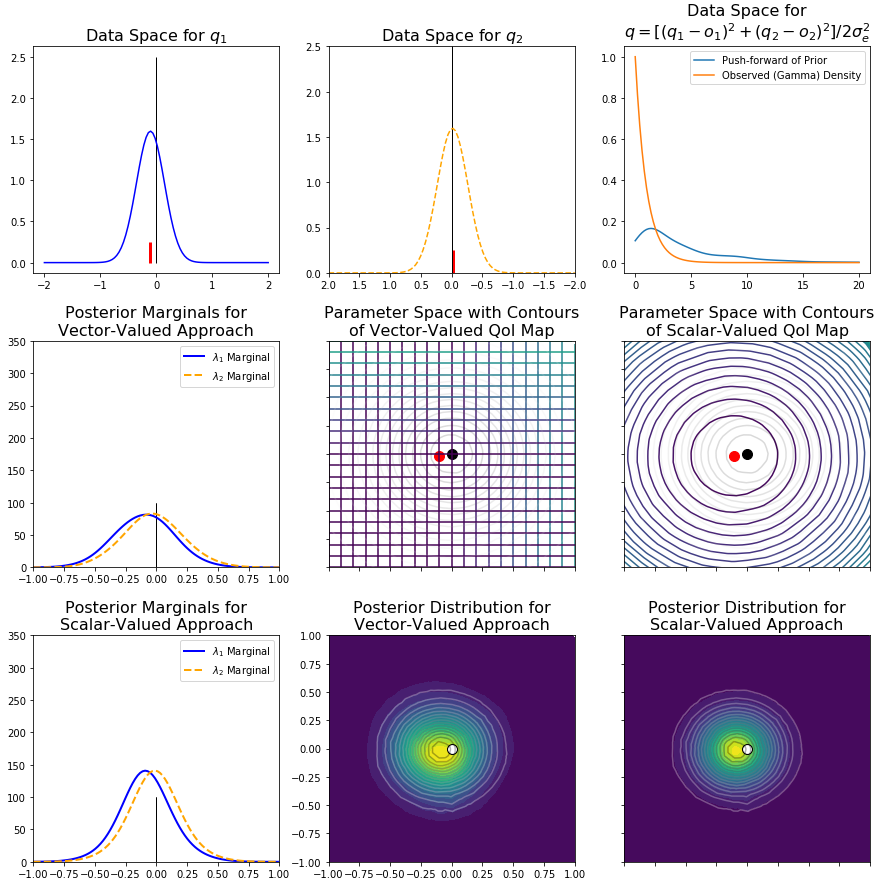

VBox(children=(HBox(children=(VBox(children=(IntSlider(value=1000, continuous_update=False, description='N', max=5000, min=100, step=100), FloatSlider(value=0.0, continuous_update=False, description='$\\mu_{\\lambda_1}$', max=0.25, min=-0.25, step=0.05), FloatSlider(value=0.0, continuous_update=False, description='$\\mu_{\\lambda_2}$', max=0.25, min=-0.25, step=0.05), FloatSlider(value=0.5, continuous_update=False, description='$\\sigma_\\lambda$', max=1.0, min=0.5, step=0.05), FloatSlider(value=0.25, continuous_update=False, description='$\\sigma_e$', max=0.5, min=0.05, step=0.01))), VBox(children=(IntSlider(value=40, continuous_update=False, description='colors', max=50, min=10, step=5), Dropdown(description='color map', options=('viridis', 'plasma', 'inferno', 'magma', 'jet', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'YlGnBu'), value='viridis'), Label(value='Change the Conditioning and Data Value Below'), FloatSlider(value=1.0, continuous_update=False, description='skewness', max=2.0, min=1.0, step=0.05), IntSlider(value=2, continuous_update=False, description='seed', max=1000))))), Output()))

In [6]:
# %%capture output
# # out = wd.interact(compare)
box = wd.VBox([gui, children[-1]])
seed.value = 2 # move the seed to trigger a run
box

# Observations

Bias prior away from observation and lower its variance. Make the data very uncertain. 
The MSE approach handles this well, while error starts to pollute the vector-valued approach.


### Skewness (squared) acts like condition number (asymptotically) for this particular QoI map

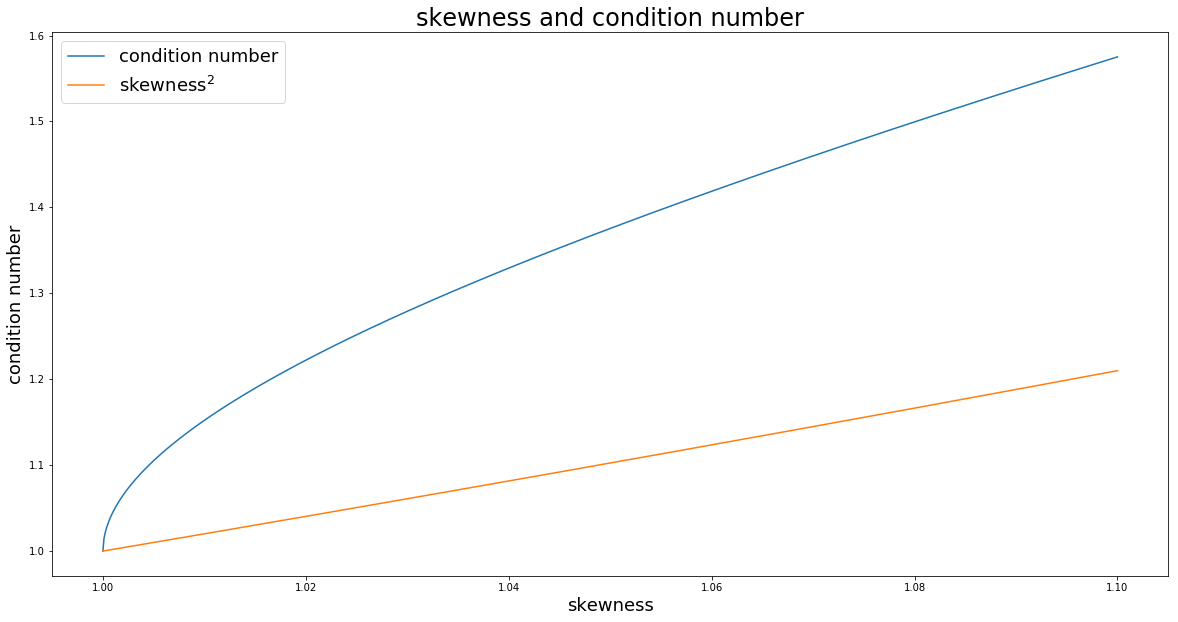

In [7]:
def skewwrap(max_skew=2, res=1000, log=False):
    skewness = np.linspace(1,max_skew,res)
    plt.figure(figsize=(20,10))
    condition = []
    for skew in skewness:
        condition.append( np.linalg.cond(skewmat(skew)) )
    plt.plot(skewness, condition, label='condition number')
    plt.plot(skewness, skewness**2, label=r'skewness$^2$')
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.ylabel('condition number',fontsize=18)
    plt.xlabel('skewness',fontsize=18)
    plt.title("skewness and condition number",fontsize=24)
    plt.legend(fontsize=18)
    plt.show()
    
wd.interactive(skewwrap, max_skew=wd.FloatSlider(min=1.1,max=10), res=wd.fixed(1000))